In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


#Need to: 
#bin commands 
#1)
#magnitude bins, percentiles: 0-25, 25-50, 50-75, 75-100
#2)
#angle bins: 8 bins starting centered at 0.  

In [31]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error']

In [50]:
df['bin'][0:56]

0    -10.0
1     -9.0
2     -8.0
3     -7.0
4     -6.0
5     -5.0
6     -4.0
7     -3.0
8     -2.0
9     -1.0
10     0.0
11     1.0
12     2.0
13     3.0
14     4.0
15     5.0
16     6.0
17     7.0
18     8.0
19     9.0
20    10.0
21    11.0
22    12.0
23    13.0
24    14.0
25    15.0
26    16.0
27    17.0
28    18.0
29    19.0
30    20.0
31    21.0
32    22.0
33    23.0
34    24.0
35    25.0
36    26.0
37    27.0
38    28.0
39    29.0
40    30.0
41    31.0
42    32.0
43    33.0
44    34.0
45    35.0
46    36.0
47    37.0
48    38.0
49    39.0
50    40.0
51    41.0
52    42.0
53    43.0
54    44.0
55   -10.0
Name: bin, dtype: float64

In [51]:
df['bin_end'][0:56]

0     54.0
1     53.0
2     52.0
3     51.0
4     50.0
5     49.0
6     48.0
7     47.0
8     46.0
9     45.0
10    44.0
11    43.0
12    42.0
13    41.0
14    40.0
15    39.0
16    38.0
17    37.0
18    36.0
19    35.0
20    34.0
21    33.0
22    32.0
23    31.0
24    30.0
25    29.0
26    28.0
27    27.0
28    26.0
29    25.0
30    24.0
31    23.0
32    22.0
33    21.0
34    20.0
35    19.0
36    18.0
37    17.0
38    16.0
39    15.0
40    14.0
41    13.0
42    12.0
43    11.0
44    10.0
45     9.0
46     8.0
47     7.0
48     6.0
49     5.0
50     4.0
51     3.0
52     2.0
53     1.0
54     0.0
55    41.0
Name: bin_end, dtype: float64

In [52]:
#Useful for analysis:
#Add a time till end of trial: 

#Trial boundaries:
# trial_start = np.where((df['trial_start']==1))[0]
trial_start = np.where((df['bin']==-10.0))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

for bnd in trial_bound:
    bin_data = df['bin'][bnd[0]:bnd[1]+1]
    df['bin_end'][bnd[0]:bnd[1]+1] = bin_data.iloc[-1]-bin_data

In [53]:
#First: Polar coordinates: 

# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']

In [142]:
df['u_v_angle'].min()*180/np.pi

-179.97251025514896

In [143]:
df['u_v_angle'].max()*180/np.pi

179.99381945207733

In [10]:
list(df.columns)

#  'u_px',
#  'u_py',
#  'u_vx',
#  'u_vy',

#  'u_v_mag',
#  'u_v_angle',

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error']

In [5]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,kin_vy,task,tc,target,trial,bin,trial_start,trial_stop,target_size,obs_size
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,1.004399,0.0,4377.0,0.0,12.0,-10.0,0.0,0.0,1.7,0.0
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,2.871518,0.0,4377.0,0.0,12.0,-9.0,0.0,0.0,1.7,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,2.696526,0.0,4377.0,0.0,12.0,-8.0,0.0,0.0,1.7,0.0
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.364251,0.0,4377.0,0.0,12.0,-7.0,0.0,0.0,1.7,0.0
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.091997,0.0,4377.0,0.0,12.0,-6.0,0.0,0.0,1.7,0.0


### BINS: 

In [134]:
#1) magnitude bins: 
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
mag_data = df['u_v_mag']
#mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
mag_bin = np.percentile(mag_data, mag_bin_perc)
mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
mag_bin_c = mag_bin_edges.mean(axis=0)

In [19]:
print(mag_bin)
print(mag_bin_edges)
print(mag_bin_c)

[0.01594599 0.86840084 1.36897591 1.97075721 7.01433267]
[[0.01594599 0.86840084 1.36897591 1.97075721]
 [0.86840084 1.36897591 1.97075721 7.01433267]]
[0.44217341 1.11868837 1.66986656 4.49254494]


In [190]:
target0_angle = -3*(2*np.pi)/8
print(target0_angle*180/np.pi)

-135.0


In [193]:
#2) angle bins: 
num_angle_bins = 8

T0_angle = -3*(2*np.pi)/8
angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
angle_bin = angle_bin_c-np.pi*2/16.0
# angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

In [ ]:
#TODO: make the bin angles match the target directions

In [194]:
print(angle_bin_c*180/np.pi)
print(angle_bin*180/np.pi)
print(angle_bin_edges*180/np.pi)

[-135.  -90.  -45.    0.   45.   90.  135.  180.  225.]
[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]
[[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]
 [-112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]]


In [198]:
#center angles for binning: 
angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
print('angle_center:', angle_center_for_binning*180/np.pi)

angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in angle_vars:
    df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [199]:
#BIN DATA: 
bin_dic = {}
bin_dic[0] = mag_bin_edges
bin_dic[1] = angle_bin_edges

data2bin = np.array(df[['u_v_mag','u_v_angle']])
bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)

In [ ]:
#Plot bins and the vector: 

In [208]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'bin_end']

<IPython.core.display.Javascript object>


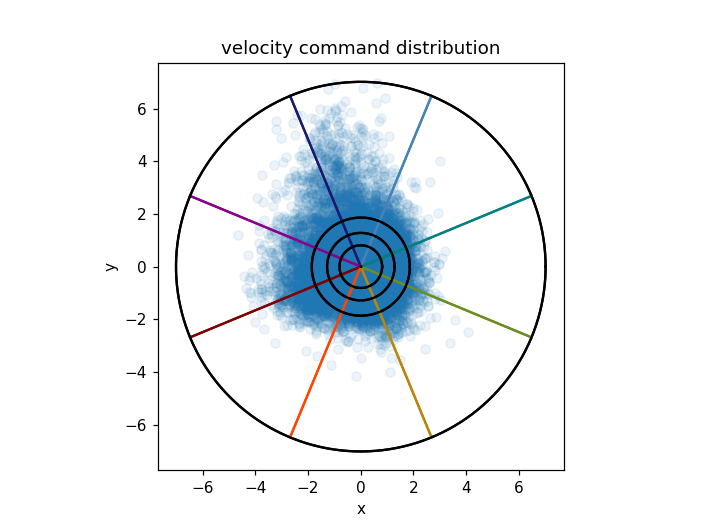

Text(0.5,1,'velocity command distribution')

In [216]:
i = 10
plt.figure()
plt.scatter(df['u_vx'], df['u_vy'],alpha=0.08)

for i,b in enumerate(angle_bin_edges.T):
    x1 = np.cos(b[0])*mag_bin[-1]
    y1 = np.sin(b[0])*mag_bin[-1]
    plt.plot([0, x1], [0, y1], color=target_color[i])
for b in mag_bin:
    theta = np.linspace(0,2*np.pi,1000)
    plt.plot(b*np.cos(theta), b*np.sin(theta), 'k')
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.title('velocity command distribution')

In [224]:
def plot_command_bin():
    for i,b in enumerate(angle_bin_edges.T):
        x1 = np.cos(b[0])*mag_bin[-1]
        y1 = np.sin(b[0])*mag_bin[-1]
        plt.plot([0, x1], [0, y1], color=target_color[i])
    for b in mag_bin:
        theta = np.linspace(0,2*np.pi,1000)
        plt.plot(b*np.cos(theta), b*np.sin(theta), 'k')
    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')

<IPython.core.display.Javascript object>


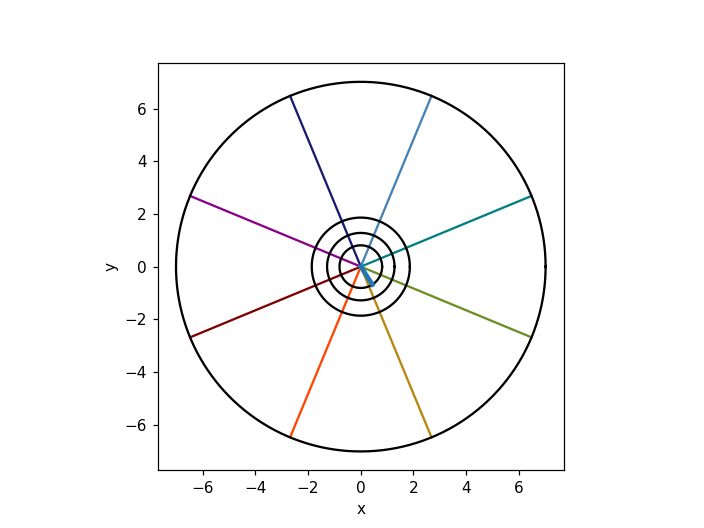

[0. 2.]


In [235]:
#Plot an individual command to confirm the binning!  : 
i = 500
x = df['u_vx'][i]
y = df['u_vy'][i]

plt.figure()
plot_command_bin()
plt.plot([0,x], [0,y],linewidth=3)
print(bin_r[i])

### ANALYSIS

In [ ]:
win = [-5, 5]
#Find